In [2]:
import spacy
import pandas as pd
from spacy.matcher import Matcher
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("merge_entities")
nlp.add_pipe("merge_noun_chunks")
import json
from matplotlib import pyplot as plt
import cv2
from elasticsearch import Elasticsearch
import re
from nltk.corpus import wordnet as wn

In [3]:
from elasticsearch import helpers
client = Elasticsearch(
    "http://localhost:9200",
     basic_auth=("elastic", "elastic")

)
resp = client.info()

In [15]:
class question_matcher:
    def __init__(self):
        self.patterns= []
        self.q_json = self.get_questions_json()
        self.matcher = Matcher(nlp.vocab)

    def get_questions_json(self):
        with open('questions.json', 'r') as f:
            pat = json.load(f)
        return pat
    
    def define_keyword(self,question:str):
        keyword = ''
        for q in self.q_json:
            if q['keyword'] in question.lower():
                keyword = q['keyword']
                index = q['qid']
        return keyword, index

    def re_get_focus(self,question:str,ind,pattern):
        question_token = [token.text for token in nlp(question)]
        focus = ''
        focus_pos = pattern['focus']
        start = 0
        i = 0
        for token in focus_pos[ind].split('\s*'):
                if(token == 'sf'):
                    start = 1
                    i = i - 1
                    continue

                if(token == 'ef'):
                    start = 0
                    break

                if(token == ".*" and start == 1):
                    j = i
                    while(j < len(question_token)):
                        focus = focus + ' ' + question_token[j]
                        j = j + 1
                    focus = focus.strip()
                    print(focus)
                    return focus

                if(start == 1):
                    focus = focus + ' ' + question_token[i]
                i = i + 1
        focus = focus.strip()
        print(focus)
        return focus

    def re_match_pattern(self,question):
        found = 0
        doc = nlp(question)
        ltoken = [token.pos_ for token in nlp(question)]
        q_pattern = ''
        for token in doc:
            q_pattern = q_pattern + token.pos_ + ' ' 
        keyword, index = self.define_keyword(question)
        for pattern in self.q_json[index]['patterns']:
            matched_pos=0
            for pos in pattern['pos']:
                regexpos  = f'({pos})'
                matches = re.fullmatch(regexpos, q_pattern)
                if matches != None:
                    # print('Matched!')
                    # print(matches.string)
                    # print(pos)
                    # print(pattern['pattern'])
                    focus = self.re_get_focus(question,matched_pos,pattern)
                    found = 1
                    return focus, pattern['answerType']
                matched_pos = matched_pos + 1
            if found == 1:
                break
 
    def pattern_to_pos(self, patterns:list):
        pos = []
        pattern = []
        for p in patterns:
            
            itr = []
            pattern.append(p)
            for token in p.split():
                if token != '*':
                    itr.append({'POS':token})
                else:
                    itr.append({})
            pos.append(itr)
        return pos
qm = question_matcher()


In [16]:

class retrive_image:
    def __init__(self):
        self.image_ids =[]
        self.image_caption =[]

    def search(self,query):
        self.image_ids =[]
        self.image_caption =[]
        query = {
            "match": {
            "caption": query
            }
        }
        resp = client.search(index="cocomo", query=query,size=100)
        #print("Got %d Hits:" % resp['hits']['total']['value'])
        for hit in resp['hits']['hits']:
            #  print(\"%(caption)s : %(image_id)s : %(id)s\" % hit[\"_source\"])\n",
            self.image_ids.append(hit['_source']['image_id'])
            self.image_caption.append(hit['_source']['caption'])
       # self.display();
        
    def display(self):
        i = 0
        plt.figure(figsize=(25,50))
        columns = 2
        for i, id in enumerate(self.image_ids):
            plt.subplot(10, 3, i + 1)
            path = '..\\..\\Cocomo2014\\\\val2014\\\\val2014\\COCO_val2014_'+ '0'*(12 - len(str(id))) + str(id) +'.jpg'
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.title(self.image_caption[i])
            plt.imshow(img)
ir = retrive_image()


In [40]:
class system:
    def __init__(self):
        qm = question_matcher()
        ir = retrive_image()
        self.image_captions = []
        self.image_ids = []
       
    def search(self,question):
        focus,eat  =  qm.re_match_pattern(question)
        print(focus)
        ir.search(focus)
        self.image_captions = ir.image_caption
        self.image_ids = ir.image_ids
s = system()

Matched!
PRON AUX NOUN ADP PROPN 
\s*PRON\s*AUX\s*(NOUN|PROPN)\s*.*\s*
who [is,was] [NAME]
the president of united states
the president of united states
Got 10000 Hits:


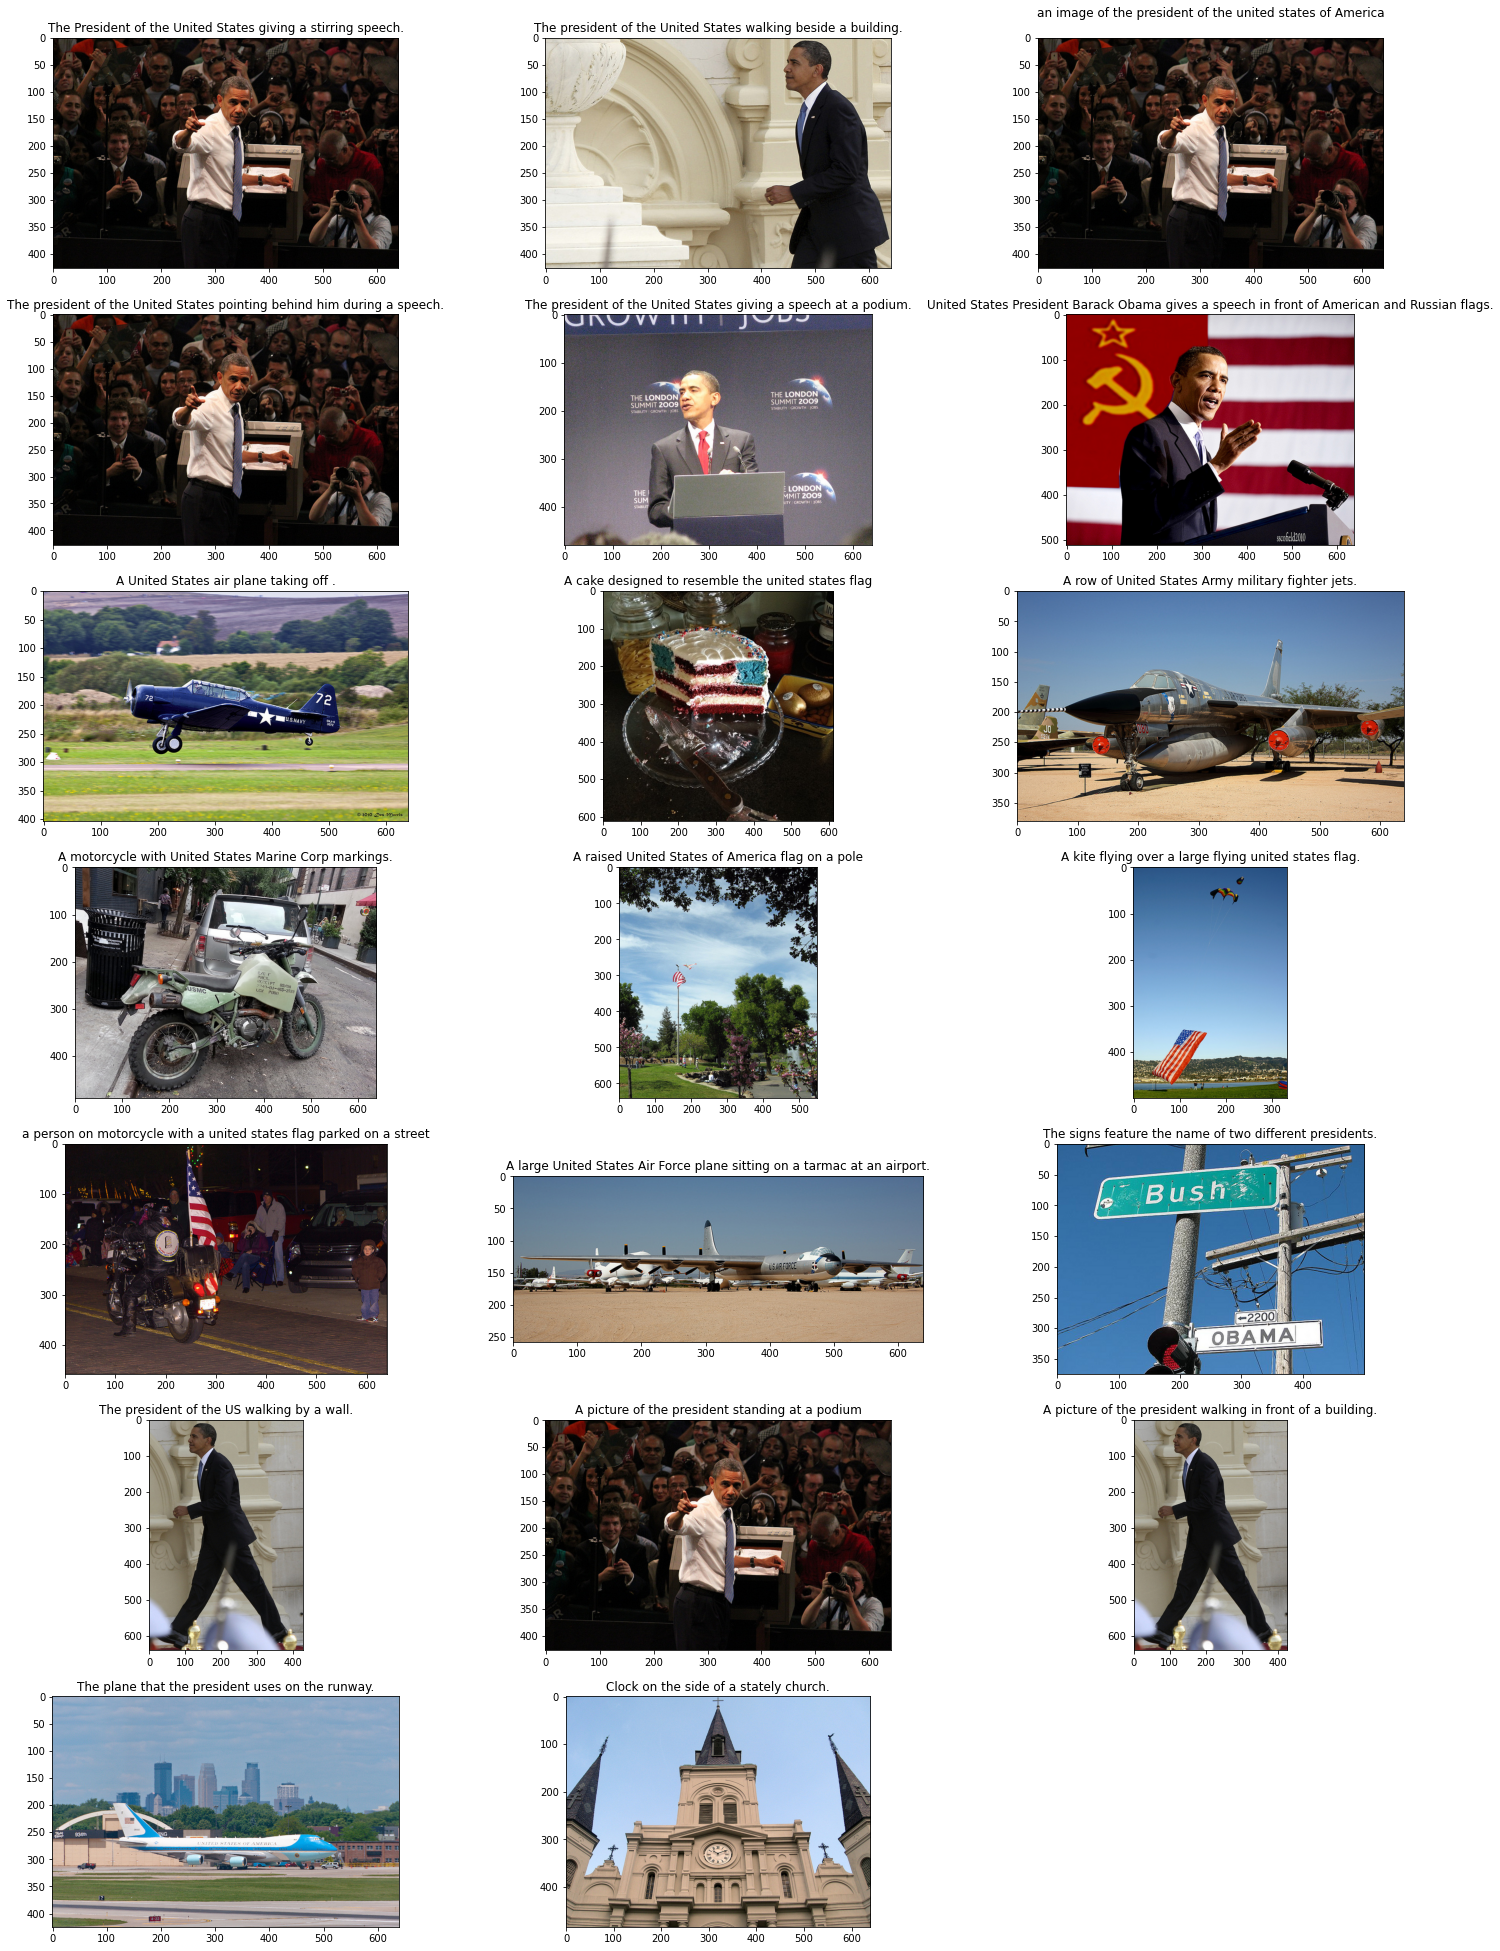

In [41]:
s.search('who is the president of united states')

In [19]:
class system1:
    def __init__(self):
        qm = question_matcher()
        ir = retrive_image()
        self.image_captions = []
        self.image_ids = []
        self.data = pd.DataFrame()
    
    def search(self,question):
        #focus, eat =  qm.re_match_pattern(question)
        #print(focus)
        ir.search('people')
       # print(eat)
        self.image_captions = ir.image_caption
        self.image_ids = ir.image_ids
        self.data = pd.DataFrame({"caption":self.image_captions, "id":self.image_ids, "EAT":[0]*len(self.image_ids),"similarity":[0]*len(self.image_ids)})
        #print(self.data.head())
        #self.get_image_with_correct_synset(eat, focus)
        self.get_image_with_number()
        self.data = self.data.sort_values(by=['EAT','similarity'],ascending=False)
        print(self.data.head(20))
        self.display(self.data.head(50)['caption'],self.data.head(50)['id'])
        #print(self.data['caption'].at[5])
    
    # def creating_query(self, qid, focus):
    #     if qid < 4:
    #         return focus
    #     if qid == 4:
            

    def get_image_with_correct_synset(self, eat:str, focus:str):
        for index, row in self.data.iterrows():
            self.data.at[index, 'similarity'] = nlp(focus).similarity(nlp(row['caption']))
            for token in row['caption'].split():
                # if(token.is_stop):
                #     continue
                #print(token)
                cond = self.check_hypernym(token, eat)

                if (cond == 'True'):
                    self.data.at[index, 'EAT'] = 1
                    # break
            
            # for ent in nlp(row['caption']).ents:
            #     if(eat == 'person' and ent.label_ == 'PERSON'):
            #         self.data.at[index, 'EAT'] = 1
                    
       # return aftercap, afterids

    def get_image_with_number(self):
        for index, row in self.data.iterrows():
            for token in row['caption'].split():
                if(nlp(token).pos_ == 'NUM'):
                    self.data.at[index, 'EAT'] = 1
            
        
    def check_hypernym(self ,word:str ,sett:str):
        word_lamma = nlp(word)[0].lemma_
        sett_lamma = nlp(sett)[0].lemma_

        if(wn.synsets(word_lamma) == []):
            return 'False'
        word_ss = wn.synsets(word_lamma)[0]

        if(wn.synsets(sett_lamma) == []):
            return 'False'
        sett_ss = set(ss.name() for ss in wn.synsets(sett_lamma))
        hypernyms_ss = {synset.name() for synset in wn.synset(word_ss.name()).hypernym_paths()[0]}
        z = sett_ss.intersection(hypernyms_ss)
        if(len(list(z)) != 0):
           # print('yezzzz')
            return 'True'
        return 'False'



    def display(self,caps,ids):
        i = 0
        plt.figure(figsize=(50,100))
        for i, id in enumerate(ids):
            plt.subplot(18, 2, i + 1)
            path = '..\\..\\Cocomo2014\\\\val2014\\\\val2014\\COCO_val2014_'+ '0'*(12 - len(str(self.data.head(50)['id'][i]))) + str(self.data.head(50)['id'][i]) +'.jpg'
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.title(self.data.head(50)['caption'][i])
            plt.imshow(img)
s1 = system1()

In [20]:
s1.search('images than contain more than three people')

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'pos_'

In [42]:
caps = s.image_captions
ids = s.image_ids

In [68]:
wn.synsets('person')

[Synset('person.n.01'), Synset('person.n.02'), Synset('person.n.03')]

In [9]:
def check_hypernym(word ,sett):
    word = nlp(word)[0].lemma_
    sett = nlp(sett)[0].lemma_
    
    if(wn.synsets(word) == []):
        return False
    word_ss = wn.synsets(word)[0]

    if(wn.synsets(sett) == []):
        return False
    sett_ss = set(ss.name() for ss in wn.synsets(sett))
   # print(sett_ss)
   # hypernyms = list()
    #for ss in word_ss:
    hypernyms_ss = {synset.name() for synset in wn.synset(word_ss.name()).hypernym_paths()[0]}
    
       # hypernyms.append(hypernyms_ss)
    #print(hypernyms)
    # for synset in hypernyms:
    z = sett_ss.intersection(hypernyms_ss)
        
    if(len(list(z)) != 0):
        print(z)
        return
    #         print(z)
    #         print(sett_ss)
    #         print(synset)
    #         break
    print('not')
    # return False
check_hypernym('President','person')

{'person.n.01'}


In [ ]:
hypernyms_ss = {synset.name() for synset in wn.synset(ss.name()).hypernym_paths()[0]}

In [86]:
word = 'father'
word = nlp(word)[0].lemma_
ss =  set(wn.synsets(word))
list(ss)

[Synset('don.n.03'),
 Synset('church_father.n.01'),
 Synset('father.n.05'),
 Synset('father.n.03'),
 Synset('father.n.01'),
 Synset('founder.n.02'),
 Synset('father.n.06'),
 Synset('beget.v.01'),
 Synset('forefather.n.01')]

In [96]:
aftercap =[]
afterids = []
for i, c in enumerate(caps):
    for word in c.split():
        if(check_synset(word, "person")):
            aftercap.append(caps[i])
            afterids.append(ids[i])


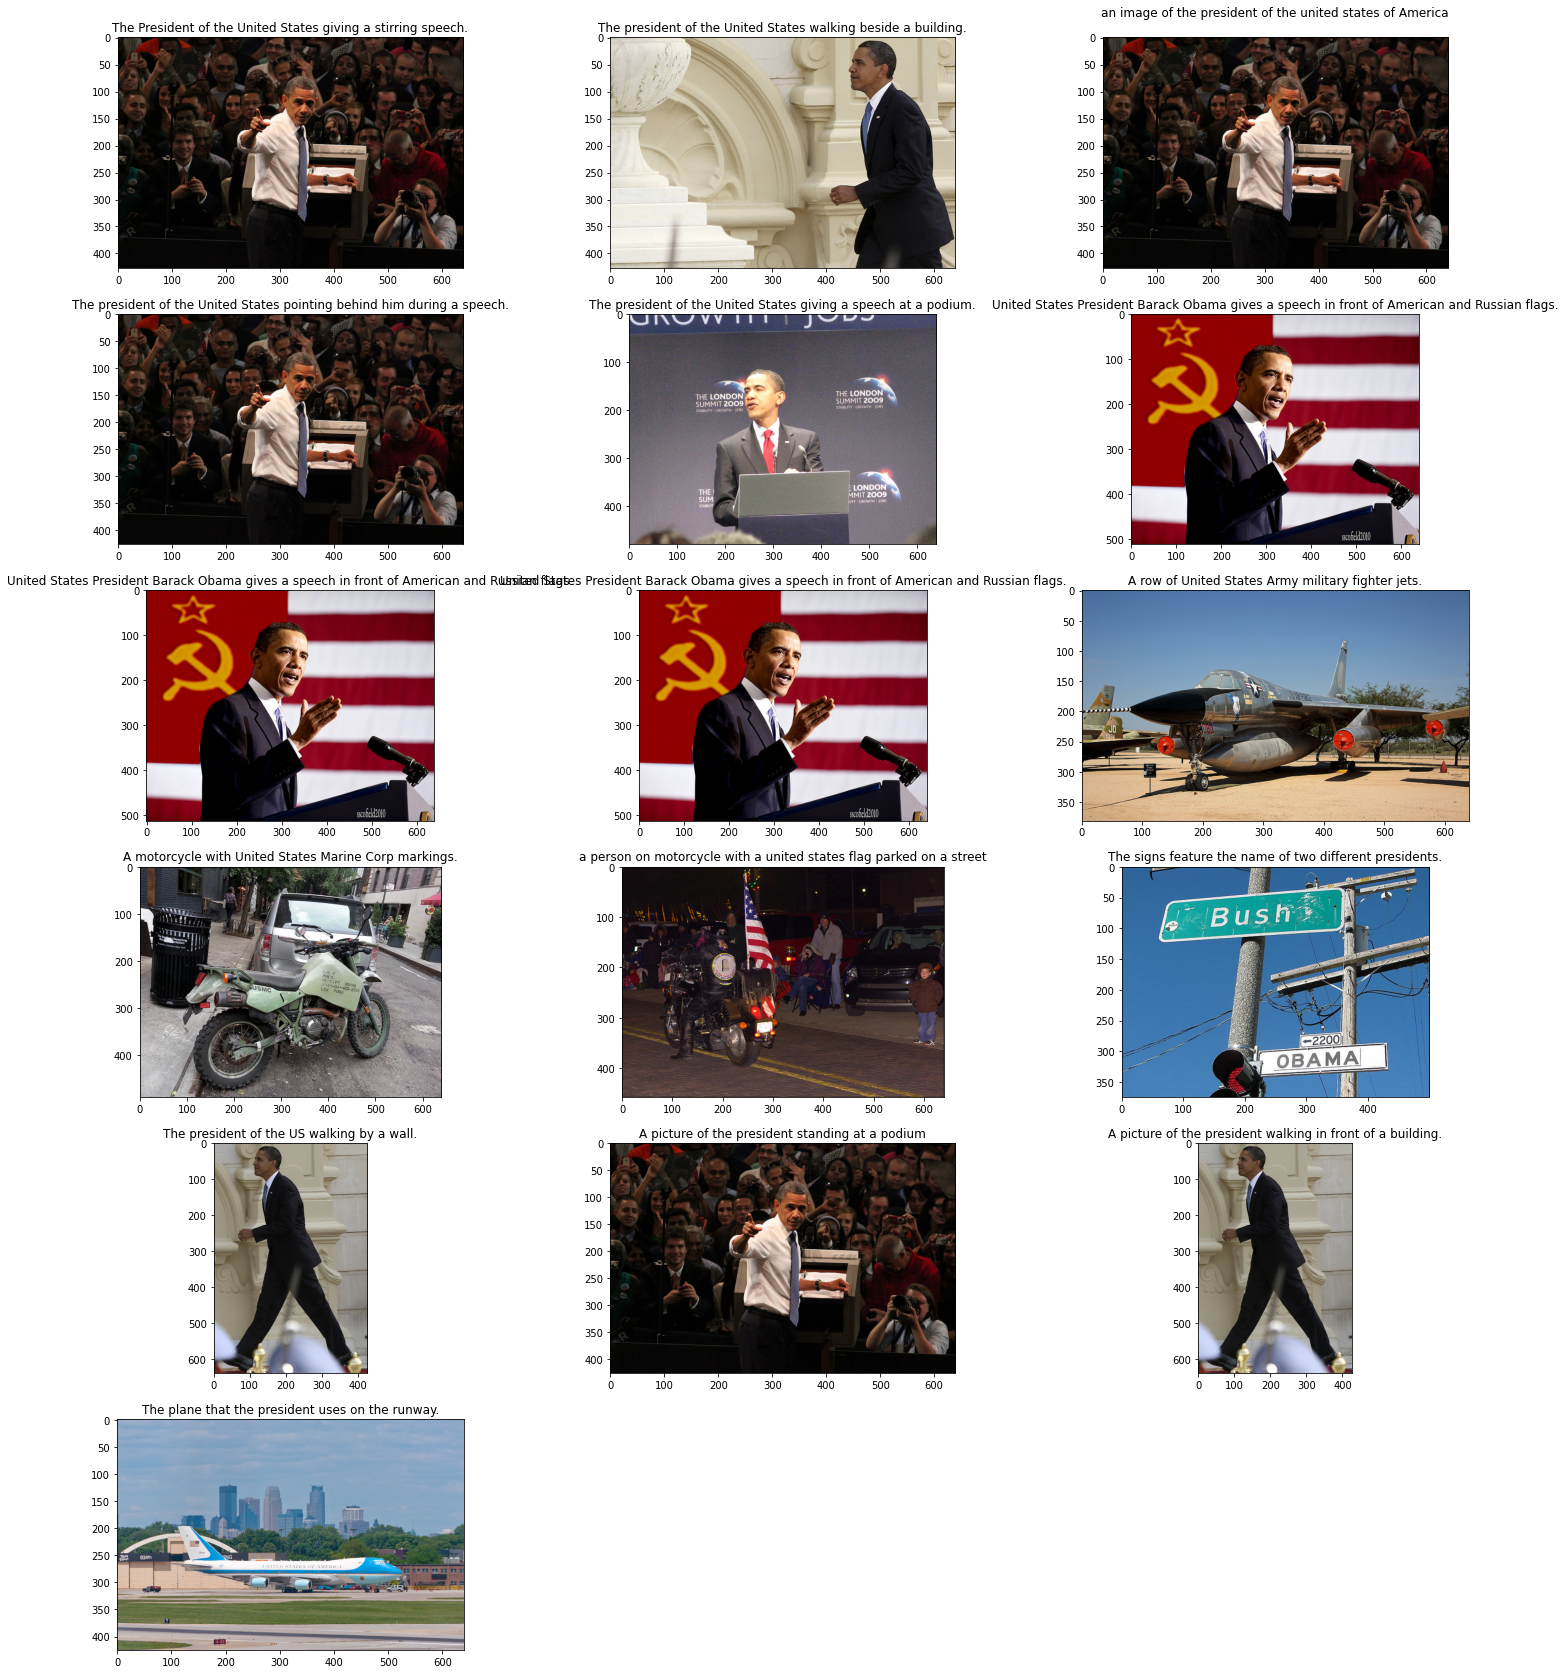

In [97]:
def display():
    i = 0
    plt.figure(figsize=(25,50))
    columns = 2
    for i, id in enumerate(afterids):
        plt.subplot(10, 3, i + 1)
        path = '..\\..\\Cocomo2014\\\\val2014\\\\val2014\\COCO_val2014_'+ '0'*(12 - len(str(id))) + str(id) +'.jpg'
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(aftercap[i])
        plt.imshow(img)
display()

In [27]:
doc1 = nlp("president of the united states")
doc2 = nlp("united states president barack obama gives a speech in from of amarican people")

# Similarity of two documents
print(doc1, "<->", doc2, doc2.similarity(doc1))

president of the united states <-> united states president barack obama gives a speech in from of amarican people 0.8304945942449244


In [138]:
wordsynset = wn.synsets('dog')[0]
print(wordsynset)
[synset.name() for synset in wn.synset(wordsynset.name()).hypernym_paths()[0]]

Synset('dog.n.01')


['entity.n.01',
 'physical_entity.n.01',
 'object.n.01',
 'whole.n.02',
 'living_thing.n.01',
 'organism.n.01',
 'animal.n.01',
 'chordate.n.01',
 'vertebrate.n.01',
 'mammal.n.01',
 'placental.n.01',
 'carnivore.n.01',
 'canine.n.02',
 'dog.n.01']

In [95]:

vehicle = wn.synset('parent.n.01')
typesOfVehicles = list(set([w for s in vehicle.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
print(typesOfVehicles)

['pop', 'pa', 'stepparent', 'para_I', 'mother-in-law', 'stepfather', 'adopter', 'dada', 'old_man', 'stepmother', 'father', 'supermom', 'mother', 'mama', 'father-in-law', 'dad', 'female_parent', 'mamma', 'pater', 'empty_nester', 'surrogate_mother', 'pappa', 'filicide', 'adoptive_parent', 'quadripara', 'mummy', 'mum', 'puerpera', 'mom', 'mammy', 'begetter', 'mommy', 'mater', 'papa', 'quintipara', 'male_parent', 'ma', 'daddy', 'primipara', 'momma']


In [29]:
def synonym_antonym_extractor(phrase):
     from nltk.corpus import wordnet
     synonyms = []
     antonyms = []

     for syn in wordnet.synsets(phrase):
          for l in syn.lemmas():
               synonyms.append(l.name())
               if l.antonyms():
                    antonyms.append(l.antonyms()[0].name())
     print(set(synonyms))
     print(set(antonyms))
synonym_antonym_extractor(phrase="house")

{'planetary_house', 'mansion', 'theater', 'sign', 'household', 'home', 'menage', 'business_firm', 'domiciliate', 'family', 'theatre', 'star_sign', 'put_up', 'sign_of_the_zodiac', 'house', 'firm'}
set()


In [4]:
doc = nlp('three people')
print([(X.text, X.label_) for X in doc.ents])

[]


In [12]:
doc = nlp('give me images that contain more than two people ')
print([X.pos_ for X in doc])

['VERB', 'PRON', 'NOUN', 'PRON', 'VERB', 'NOUN']


In [25]:
[synset.name() for synset in wn.synset('sea.n.01').hypernym_paths()[0]]

['entity.n.01',
 'physical_entity.n.01',
 'thing.n.12',
 'body_of_water.n.01',
 'sea.n.01']

In [65]:
def creating_query(caption:str):
    caption = caption.lower()
    must = []
    must_not = []
    should = []
    lcaption = caption.split()
    for i,word in enumerate(caption.split()):
        hh
           
creating_query("caption and me")

yes
